# Siamese model for fingerprint identification / matching

This notebook will train a Siamese model to encode a grayscale image of a fingerprint (90*97 pixels) into a vector of size 128. The Siamese model will be trained in a way that the dot product of two such vectors will return the similarity of the corresponding fingerprints.

The trained model managed to match 8188 test fingerprints (never been seen while training) to 1000 unique test fingerprints with roughly **98% accuracy**.

The dataset consists of fingerprints for 600 people, all their ten fingers. That results in 6000 unique fingerprints each of which is considered a separate sample here. There are also altered (synthetic) versions of the same fingerprints grouped into 3 levels of difficulties (according to the provider of the dataset), easy, medium, and hard. As it will be shown, a Siamese model requires variations of the same sample and the afforementioned difficulty levels are used for that purpose. Also, some random image transformation is applied to images to improve the robustness of the trained model as an augmentation technique. These random trasformations are also applied to the test images. Without this last part, it would have been too easy of a problem to solve. Basically, if you run the test evaluation multiple times on the same trained model, you'll end up with different results because of the random factor applied to the test dataset.

## 1. Let's start

The following block is a boilerplate cell provided by Kaggle and it will simply count the number of files in each folder. It is worth mentioning that there are different alterations applied to each sample but since the result should have been a valid fingerprint, not all samples were a good candidate to receive all the alterations. That's why the number of files in each folder seems random.

Please refer to the [dataset's paper](https://arxiv.org/abs/1807.10609) for the complete description.

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input/socofing/SOCOFing'):
    print(dirname, len(filenames))
    #for filename in filenames:
        #print(os.path.join(dirname, filename))

/kaggle/input/socofing/SOCOFing 0
/kaggle/input/socofing/SOCOFing/Altered 0
/kaggle/input/socofing/SOCOFing/Altered/Altered-Hard 14272
/kaggle/input/socofing/SOCOFing/Altered/Altered-Easy 17931
/kaggle/input/socofing/SOCOFing/Altered/Altered-Medium 17067
/kaggle/input/socofing/SOCOFing/Real 6000


### 2. Preparing to install Trax

The model will be implemented using Trax. Since Trax is not provided by Kaggle, it needs to be installed manually. If for you it's already installed, you can skip to step 3.

Trax uses JAX for leveraging the GPU (or TPU) so we need to install JAX as well. FOr that, we'll need to know the version of the Cuda available first.

The version of the avaiable Cuda should be taken and put in the following cell.

Please refer to the [JAX's Github page](https://github.com/google/jax#pip-installation) if you need to make any changes.

In [ ]:
#IMPORTANT: You might need to update these values based on the outputs of previous cells
# Please refer to this link to learn how: https://github.com/google/jax#pip-installation
import os

os.environ['JAX_CUDA_VERSION'] = 'cuda12'
os.environ['JAX_BASE_URL'] = 'https://storage.googleapis.com/jax-releases/jax_releases.html'

!pip install --upgrade "jax[cuda12_pip]" -f $JAX_BASE_URL

Just checking to make sure the GPU is accessible

In [4]:
from jax.lib import xla_bridge

jax_platform = xla_bridge.get_backend().platform

if jax_platform == "cpu":
    print("No acceleration is found for JAX. It is not recommended to continue.")
else:
    print("JAX with {} acceleration is found, you may continue.".format(jax_platform))

JAX with gpu acceleration is found, you may continue.


Finally, installing Trax.

In [ ]:
!pip install trax

## 3. Loading the dataset

First let's start by listing all the files. Just for the sake of better understanding what we are dealing here with, let's plot one sample and three of its alterations. You might notice that each image has two extra pixels on the top and left and four extra pixels on the right and bottom.

The very listed filename: 445__M_Right_ring_finger.BMP


<Figure size 432x288 with 0 Axes>

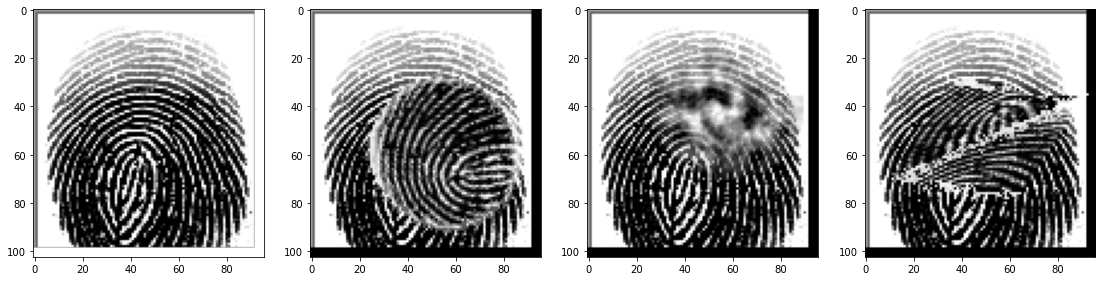

In [7]:
from os import listdir
from os.path import isfile, join
import math
import cv2
import matplotlib.pyplot as plt
import matplotlib

src_folder = "/kaggle/input/socofing/SOCOFing"

real_filenames = [f for f in listdir(join(src_folder, "Real"))
                  if isfile(join(src_folder, "Real", f))]
digit_count = math.ceil(math.log10(len(real_filenames) + 1))

easy_filenames = [f for f in listdir(join(src_folder, "Altered", "Altered-Easy"))
                  if isfile(join(src_folder, "Altered", "Altered-Easy", f))]
medium_filenames = [f for f in listdir(join(src_folder, "Altered", "Altered-Medium"))
                    if isfile(join(src_folder, "Altered", "Altered-Medium", f))]
hard_filenames = [f for f in listdir(join(src_folder, "Altered", "Altered-Hard"))
                  if isfile(join(src_folder, "Altered", "Altered-Hard", f))]

print("The very listed filename: {}".format(real_filenames[0]))

real = matplotlib.image.imread(join(src_folder, "Real", "1__M_Left_index_finger.BMP"))
alt_cr = matplotlib.image.imread(join(src_folder, "Altered", "Altered-Hard", "1__M_Left_index_finger_CR.BMP"))
alt_obl = matplotlib.image.imread(join(src_folder, "Altered", "Altered-Hard", "1__M_Left_index_finger_Obl.BMP"))
alt_zcut = matplotlib.image.imread(join(src_folder, "Altered", "Altered-Hard", "1__M_Left_index_finger_Zcut.BMP"))

plt.figure()
plt.figure(figsize=(24, 25))
plt.subplot(1, 5, 1, facecolor='w')
plt.imshow(real, cmap='gray')
plt.subplot(1, 5, 2, facecolor='w')
plt.imshow(alt_cr, cmap='gray')
plt.subplot(1, 5, 3, facecolor='w')
plt.imshow(alt_obl, cmap='gray')
plt.subplot(1, 5, 4, facecolor='w')
plt.imshow(alt_zcut, cmap='gray')

Next, load the images into memory using OpenCV. I used OpenCV for its simplicity and also later I'll use OpenCV to implement a random transformation playing the role of augmentation. As mentioned before there are some extra pixels in all of the images that are removed. Also, some of the files are not the same size (number of pixels) so a resize will make sure they all will end up exactly the same.

Out of the 6000 real fingerprints, we'll use 4000 for training, 1000 for validation, and 1000 for testing. The altered version of each fingerprint will be used along its original version. So an alteration of a training will also be used for training and an altered version of the test will also be used for testing.

There are also a bunch of dictionaries populated which will come handy later on.

In [8]:
from collections import defaultdict
import cv2


# Each finger (regardless of who it blongs to or which finger it is) will have an entry
# in this dictionary. And each entry is a list while variations of the finger are entries
# of the list. Something like: {"1": ["/path_to_the_file/1__M_Left_index_finger.BMP", ...]}
# Basically, we are grouping all variations of the same fingerprint. One real
# and the rest altered
unique_sample = defaultdict(list)

for fn in real_filenames:
    unique_sample[fn[:fn.rindex(".")]] += [join(src_folder, "Real", fn)]
for fn in easy_filenames:
    unique_sample[fn[:fn.rindex("_")]] += [join(src_folder, "Altered", "Altered-Easy", fn)]
for fn in medium_filenames:
    unique_sample[fn[:fn.rindex("_")]] += [join(src_folder, "Altered", "Altered-Medium", fn)]
for fn in hard_filenames:
    unique_sample[fn[:fn.rindex("_")]] += [join(src_folder, "Altered", "Altered-Hard", fn)]

# There are some unwanted pixels around the input images, this function will get rid of them
def load_image(file_path):
    # Load the image grayscale
    img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    # Get rid of the excess pixels
    img = img[2:-4, 2:-4]
    # make sure all the images are of the same size (90 * 97)
    img = cv2.resize(img, (90, 97))
    return img

# The number of samples per each group
training_sample_count = 4000
validation_sample_count = 1000
test_sample_count = 1000

# "0000_00" -> "/.../Real/1__M_Left_index_finger.BMP"
id2path = {}
# "0000_00" -> Mat/np.array
dataset_images = {}
# "0000" -> ["00", "01", ...]
training_ids = defaultdict(list)
# "4000" -> ["00", "01", ...]
validation_ids = defaultdict(list)
# "5000" -> ["00", "01", ...]
test_ids = defaultdict(list)

for sample_id, sample in enumerate(unique_sample.items()):
    for variation_id, f in enumerate(sample[1]):
        # Polish and move the files into new folders. New filenames: {sample_id}_{variation}.png
        zero_padded_sample_id = str(sample_id).zfill(digit_count)
        zero_padded_variation_id = str(variation_id).zfill(2)
        new_id =  "{}_{}".format(zero_padded_sample_id, zero_padded_variation_id)
        id2path[new_id] = f
        dataset_images[new_id] = load_image(f)

        # Have the ids in three separate dicitonaries: sample_id -> [variation_id]
        if sample_id < training_sample_count:
            training_ids[zero_padded_sample_id] += [zero_padded_variation_id]
        elif sample_id < training_sample_count + validation_sample_count:
            validation_ids[zero_padded_sample_id] += [zero_padded_variation_id]
        else:
            test_ids[zero_padded_sample_id] += [zero_padded_variation_id]

print("There are {} samples in the training dataset".format(sum([len(ids) for ids in training_ids.values()])))
print("There are {} samples in the validation dataset".format(sum([len(ids) for ids in validation_ids.values()])))
print("There are {} samples in the test dataset".format(sum([len(ids) for ids in test_ids.values()])))

There are 36846 samples in the training dataset
There are 9236 samples in the validation dataset
There are 9188 samples in the test dataset


Defining the data generator and an image transformer as data augmentation

In [9]:
import numpy as np
import random as rnd
import cv2


eps = np.finfo(np.float32).eps

def data_generator(images, dataset, batch_size, image_transformer=None, shuffle=True):
    """Generator function that yields batches of images

    Args:
        folder (string): The path to the folder holder images
        batch_size (int): Number of elements per batch.
        image_transformer (function, optional): If provided is applied to each image before using it
        shuffle (bool, optional): If the batches should be randomnized or not. Defaults to True.
    Yields:
        tuple: Of the form (input1, input2) with types (numpy.ndarray, numpy.ndarray)
        NOTE: input1: inputs to the model [img1a, img2a, img3a, ...]
              input2: targets to the model [img1b, img2b, img3b, ...] i.e. (img1a, img1b) belong to the same fingerprint
    """

    if len(dataset) < batch_size:
        print("Batch size set to " + str(len(dataset)) + " as that's the total number of records")
        batch_size = len(dataset)

    if shuffle:
        indices = rnd.sample(list(dataset.keys()), len(dataset))
    else:
        indices = list(dataset.keys())

    idx = 0
    input1 = []
    input2 = []

    while True:
        if idx >= len(indices):
            idx = 0
            if shuffle:
                indices = rnd.sample(list(dataset.keys()), len(dataset))

        variations = rnd.sample(dataset[indices[idx]], 2)
        id1 = indices[idx] + "_" + variations[0]
        id2 = indices[idx] + "_" + variations[1]
        input1.append(id1)
        input2.append(id2)
        idx += 1

        if len(input1) == batch_size:
            b1 = []
            b2 = []
            if image_transformer is not None:
                for f1, f2 in zip(input1, input2):
                    b1.append(image_transformer(images[f1]))
                    b2.append(image_transformer(images[f2]))
            else:
                for f1, f2 in zip(input1, input2):
                    b1.append(images[f1])
                    b2.append(images[f2])

            yield np.array(b1), np.array(b2)
            input1, input2 = [], []


def prepare_random_image(image, angle1=-45.0, angle2=45.0, scale1=.9, scale2=1.1, dx1=-10, dx2=10, dy1=-10, dy2=10):
    angle = rnd.uniform(angle1, angle2)
    scale = rnd.uniform(scale1, scale2)
    dx = rnd.randint(dx1, dx2)
    dy = rnd.randint(dy1, dy2)
    
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, scale)
    trnl_mat = np.float32([ [0, 0, dx], [0, 0, dy] ])
    trns_mat = trnl_mat + rot_mat
    result = cv2.warpAffine(image, trns_mat, image.shape[1::-1],
                            flags=cv2.INTER_LINEAR,
                            borderValue=(255, 255, 255))
    return np.expand_dims(result, axis=-1).astype(np.float32)

## 4. Defining the Siamese model

A Siamese model, as the name suggests, is composed of two or more towers of layers. Since here the input is of tpye image, CNN is the best choice for the towers. Here, we'll have one tower paralleled twice. The important part of the tower is the very last "Normalize" layer which will make sure the output vectors are of L2 norm equal to 1. The importance of this will be revealed once you understand the loss function.

The loss function used here is a [triplet loss function](https://en.wikipedia.org/wiki/Triplet_loss#:~:text=Triplet%20loss%20is%20a%20loss,a%20negative%20(falsy)%20input.). The loss function takes in two batches of vectors, v1 and v2. This because the model is a Parallel. The general idea of the loss function is to calculate the similarity of its two inputs and reward/punish pairs of the vectors in v1 and v2 based on the fact whether they are similar or not. The similarity measure used here is [Cosine Similarity](https://en.wikipedia.org/wiki/Cosine_similarity) which is an angualr similarity and it could be calculated simply using a dot product as long as the vectors are of L2 norm of 1. That's why there's a normalization layer at the very end of the Siamese's tower.

Once trained, the tower can be used as an encoder that encodes the input images into vectors of 128. And thanks to the triplet loss function and the normalization layer, the similarity of such encoded vectors can easily be calculated by a dot product.

In [13]:
import os
import trax
from trax import layers as tl
from trax.supervised import training
from trax.fastmath import numpy as fastnp
import numpy as np
from functools import partial


def Siamese(d_model=128):
    """Returns a Siamese model.

    Args:
        d_model (int, optional): Size of the output encoding vectors. Defaults to 128.
        mode (str, optional): 'train', 'eval' or 'predict', predict mode is for fast inference. Defaults to 'train'.

    Returns:
        trax.layers.combinators.Parallel: A Siamese model 
        trax.layers.combinators.Serial: The encoder
    """

    def normalize(x):  # normalizes the vectors to have L2 norm 1
        return x / fastnp.sqrt(fastnp.sum(x * x, axis=-1, keepdims=True))

    encoder = tl.Serial(
        tl.Conv(16, (3, 3), padding='VALID'),
        tl.MaxPool(pool_size=(3, 3), padding='VALID'),
        tl.Conv(32, (3, 3), padding='VALID'),
        tl.MaxPool(pool_size=(3, 3), padding='VALID'),
        tl.Fn('Flatten', lambda x: fastnp.reshape(x, (x.shape[0], np.prod(x.shape[1:])))),
        tl.Dense(d_model*2),
        tl.Relu(),
        tl.Dense(d_model*3),
        tl.Relu(),
        tl.Dense(d_model),
        tl.Fn('Normalize', lambda x: normalize(x)),
    )

    model = tl.Parallel(encoder, encoder)
    return model, encoder


def TripletLossFn(v1, v2, margin=0.25):
    """Custom Loss function, where the magic happens

    Args:
        v1 (numpy.ndarray): Array with dimension (batch_size, d_model)
        v2 (numpy.ndarray): Array with dimension (batch_size, d_model)
        margin (float, optional): Desired margin. Defaults to 0.25.

    Returns:
        jax.interpreters.xla.DeviceArray: Triplet Loss.
    """

    scores = fastnp.dot(v1, v2.T)
    batch_size = len(scores)
    positive = fastnp.diagonal(scores)
    negative_without_positive = scores - (fastnp.eye(batch_size) * 2.0)
    closest_negative = negative_without_positive.max(axis=1)
    negative_zero_on_duplicate = fastnp.multiply(scores, 1.0 - fastnp.eye(batch_size))
    mean_negative = fastnp.sum(negative_zero_on_duplicate, axis=1) / (batch_size - 1)
    triplet_loss1 = fastnp.maximum(0.0, margin + closest_negative - positive)
    triplet_loss2 = fastnp.maximum(0.0, margin + mean_negative - positive)
    triplet_loss = fastnp.mean(triplet_loss1 + triplet_loss2)

    return triplet_loss


def TripletLoss(margin=0.25):
    triplet_loss_fn = partial(TripletLossFn, margin=margin)
    return tl.Fn('TripletLoss', triplet_loss_fn)


def accuracy(v1, v2):
    scores = fastnp.dot(v1, v2.T)
    m = fastnp.argmax(scores, axis=-1)
    i = fastnp.arange(len(m))
    mark_list = fastnp.where(i == m, 1, 0)
    mark = fastnp.sum(mark_list)
    return mark / len(mark_list)


def train_model(model, loss_fn, lr_schedule, train_generator, val_generator, train_steps, output_dir=None):
    """Training the Siamese Model

    Args:
        Siamese (function): Function that returns the Siamese model.
        TripletLoss (function): Function that defines the TripletLoss loss function.
        lr_schedule (function): Trax multifactor schedule function.
        train_generator (generator, optional): Training generator. Defaults to train_generator.
        val_generator (generator, optional): Validation generator. Defaults to val_generator.
        output_dir (str, optional): Path to save model to. Defaults to 'model/'.

    Returns:
        trax.supervised.training.Loop: Training loop for the model.
    """
    if output_dir is not None:
        output_dir = os.path.expanduser(output_dir)

    train_task = training.TrainTask(
        labeled_data=train_generator,
        loss_layer=loss_fn(),
        optimizer=trax.optimizers.Adam(0.01),
        lr_schedule=lr_schedule,
        n_steps_per_checkpoint=1000,
    )

    eval_acc_task = training.EvalTask(
        labeled_data=val_generator,
        metrics=[loss_fn(), tl.Fn('Accuracy', accuracy)],
        metric_names=["Eval Loss", "Eval Acc"],
    )

    training_loop = training.Loop(model,
                                  train_task,
                                  eval_tasks=[eval_acc_task],
                                  output_dir=output_dir,
                                  checkpoint_at=lambda n: n == train_steps) # Only savev the very last step

    return training_loop

## 5. Training the model

Before training the model, it's worth mentioning the importance of the batch size in this model. Going back to the definition of the triplet loss function, the loss value calculated for each batch is a function of a matrix of size (batch_size, batch_size). This means the bigger the batch size, the more accurate the loss value. Long story short, you should have the batch size as large as your hardware supports. While this improves the training time, it will have a very significant impact on the quality of the trained model as well.

The training is set to go on for 12000 steps. This should take an hour on Kaggle to complete.

In [31]:
batch_size = 768
train_steps = 12000

train_generator = data_generator(dataset_images, training_ids, batch_size, image_transformer=prepare_random_image)
val_generator = data_generator(dataset_images, validation_ids, batch_size, image_transformer=prepare_random_image)

model, encoder = Siamese()

lr_schedule = trax.lr.warmup_and_rsqrt_decay(200, 0.0099)

training_loop = train_model(model, TripletLoss, lr_schedule, train_generator, val_generator, train_steps)
training_loop.run(train_steps)

Will not write evaluation metrics, because output_dir is None.

Step      1: Total number of trainable weights: 59938240
Step      1: Ran 1 train steps in 1.45 secs
Step      1: train TripletLoss |  0.52361548
Step      1: eval    Eval Loss |  0.49930495
Step      1: eval     Eval Acc |  0.02734375

Step   1000: Ran 999 train steps in 287.85 secs
Step   1000: train TripletLoss |  0.27948594
Step   1000: eval    Eval Loss |  0.26058304
Step   1000: eval     Eval Acc |  0.09505209

Step   2000: Ran 1000 train steps in 287.04 secs
Step   2000: train TripletLoss |  0.25807127
Step   2000: eval    Eval Loss |  0.25767091
Step   2000: eval     Eval Acc |  0.13541667

Step   3000: Ran 1000 train steps in 286.72 secs
Step   3000: train TripletLoss |  0.25547823
Step   3000: eval    Eval Loss |  0.25157675
Step   3000: eval     Eval Acc |  0.42317709

Step   4000: Ran 1000 train steps in 287.23 secs
Step   4000: train TripletLoss |  0.20209607
Step   4000: eval    Eval Loss |  0.17011607
Step  

## 6. Evaluate the model

In order to evaluate the model, the test dataset is split into two sets, the real fingerprints and their alterations. The process is like this:

1. Encode the real fingerprints into vectors. There are exactly 1000 real fingerprints in the test dataset.
1. Encode the altered versions into vectors as well. There are 8188 altered samples in the test dataset.
1. Calculate the dot product between the encoded version of the real fingerprints and the altered. This results is a matrix of size (8188, 1000) showing the similarity between each altered sample and all the real versions.
1. The most similar (largest number) per each row (A.K.A. altered sample) should be the column representing the real fingerprint. Basically, using the similarity matrix, we should be able to tell the real fingerprint of an altered one (that is, if the model works).
1. The accuracy is calcualted by counting the correctly found real fignerprints per total number of altered ones.

As mentioned before, the random image transformation is also applied on the test dataset. If this was not done, it would be a much simpler propblem and the accuracy will be higher.

In [32]:
from os.path import basename

stem_ids = ["{}_{}".format(sample_id, variation_id)
            for sample_id, variation_list in test_ids.items()
            for variation_id in variation_list
            if "/Real/" in id2path["{}_{}".format(sample_id, variation_id)]]
test_stem = np.stack([prepare_random_image(dataset_images[id])
                      for id in stem_ids], axis=0)

query_ids = ["{}_{}".format(sample_id, variation_id)
             for sample_id, variation_list in test_ids.items()
             for variation_id in variation_list
             if "/Real/" not in id2path["{}_{}".format(sample_id, variation_id)]]
test_query = np.stack([prepare_random_image(dataset_images[id])
                      for id in query_ids], axis=0)

# It could be done in one go if Kaggle provided more memory
chunk_size = 200
stem_encoded = np.concatenate([encoder(test_stem[i:i + chunk_size, ...])
                               for i in range(0, test_stem.shape[0], chunk_size)],
                              axis=0)
query_encoded = np.concatenate([encoder(test_query[i:i + chunk_size, ...])
                                for i in range(0, test_query.shape[0], chunk_size)],
                               axis=0)
similarity = fastnp.dot(query_encoded, stem_encoded.T)
matched = fastnp.argmax(similarity, axis=-1)

In order to better understand the quality of the answers, there are three histograms plotted as well.

1. On the left: the distribution of the similarities for correctly matched fingerprints.
1. On the middle: the distribution of the similarities for incorrectly matched fingerprints.
1. On the right: the distribution of the similarities for all the fingerprints.

In [38]:
def plot_result(name, input2include):
    query_ids2 = [id[:digit_count] for id in query_ids]
    stem_ids2 = [id[:digit_count] for id in stem_ids]

    results = [1 if query_ids2[input] == stem_ids2[output] else 0
               for (input, output) in enumerate(matched)
               if input in input2include]
    correct_answers = sum(results)
    total_tests = len(results)
    acc = correct_answers / total_tests * 100.0
    del results

    print()
    print("Got {} right out of {}, that's {:.2f}% accuracy".format(correct_answers, total_tests, acc))
    print()

    scores = similarity.tolist()
    plt.figure(figsize=(25, 8))

    plt.subplot(1, 3, 1, facecolor='w')
    correctly_matched_scores = [scores[input][output]
                                for (input, output) in enumerate(matched)
                                if query_ids2[input] == stem_ids2[output]
                                and input in input2include]
    plt.hist(correctly_matched_scores, bins=100, range=(0.0, 1.0), label="Correctly matched")
    plt.xlabel('Similarity')
    plt.ylabel('Number of matched')
    plt.title("Distribution of correctly matched for {} fingerprints (Acc: {:.2f}%)"
              .format(name, acc))
    del correctly_matched_scores

    plt.subplot(1, 3, 2, facecolor='w')
    incorrectly_matched_scores = [scores[input][output]
                                  for (input, output) in enumerate(matched)
                                  if query_ids2[input] != stem_ids2[output]
                                  and input in input2include]
    plt.hist(incorrectly_matched_scores, bins=100, range=(0.0, 1.0), label="Incorrectly matched")
    plt.xlabel('Similarity')
    plt.ylabel('Number of matched')
    plt.title("Distribution of incorrectly matched for {} fingerprints (Acc: {:.2f}%)"
              .format(name, acc))

    scores = similarity[list(input2include), :].reshape((-1,)).tolist()
    plt.subplot(1, 3, 3, facecolor='w')
    plt.hist(scores, bins=200, range=(-1.0, 1.0), label="Correctly not matched")
    plt.xlabel('Similarity')
    plt.ylabel('Number of matched')
    plt.title("Distribution of all similarities calculated for {} fingerprints (Acc: {:.2f}%)"
              .format(name, acc))

    plt.show()

### Histograms for all the test dataset (regardless of their difficulty level)

= Not considering the difficulty level of the samples =

Got 8067 right out of 8188, that's 98.52% accuracy



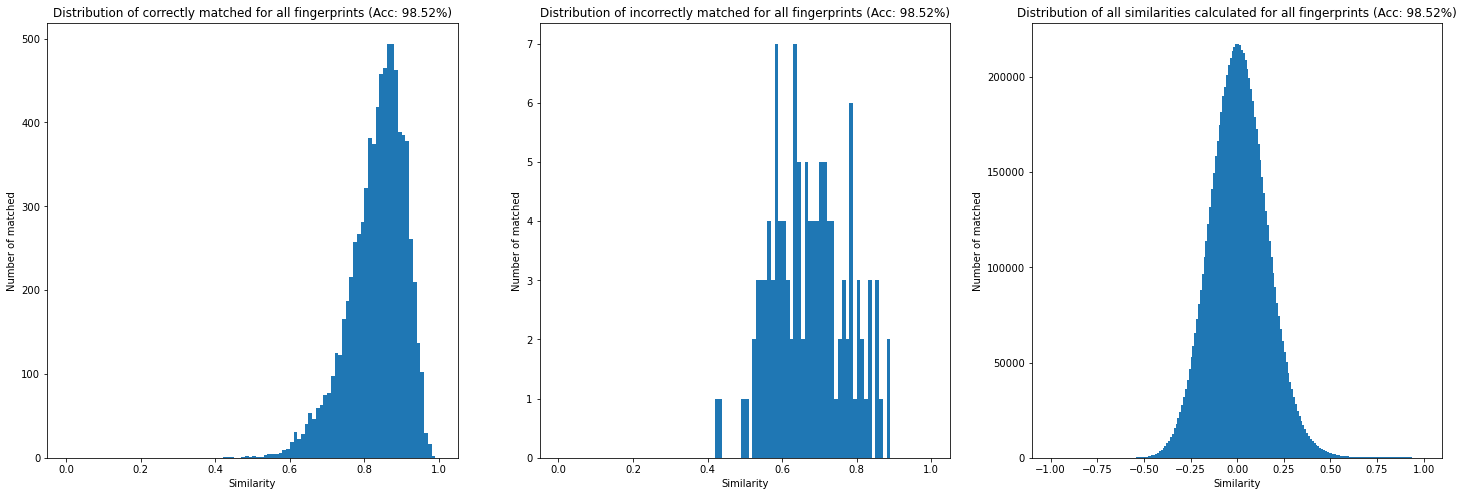

In [40]:
print("=======================================================")
print("= Not considering the difficulty level of the samples =")
print("=======================================================")

plot_result("all", set(range(len(matched))))

### Histograms for the easy subset of test dataset

= Only considering the easy samples =

Got 2961 right out of 2982, that's 99.30% accuracy



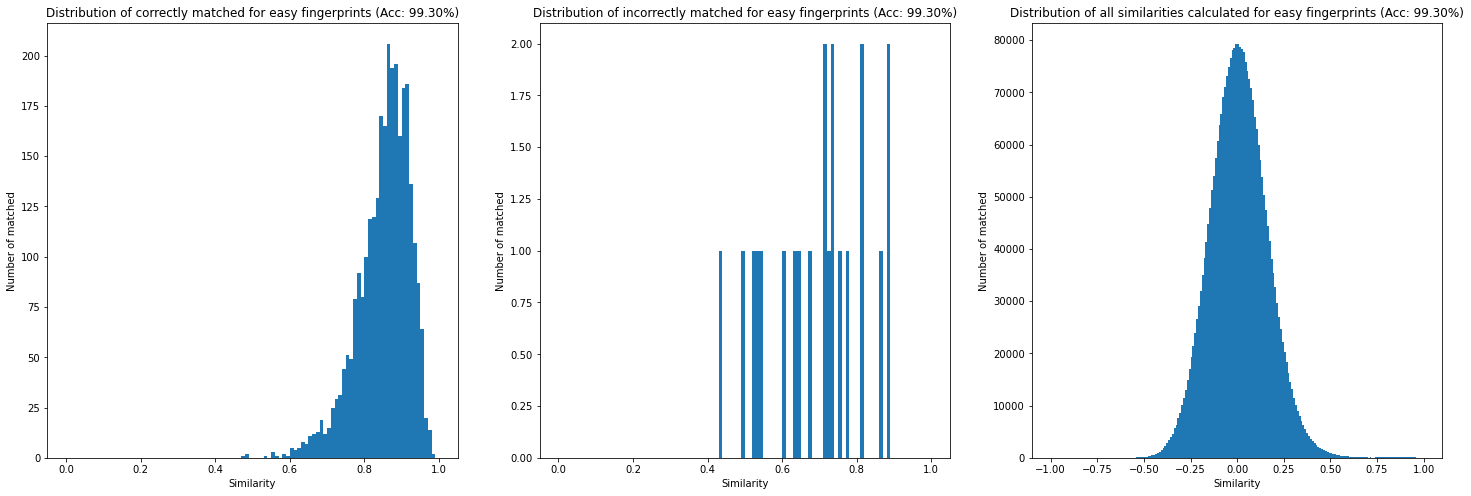

In [35]:
print("=====================================")
print("= Only considering the easy samples =")
print("=====================================")

easy_indices = [i
                for i, id in enumerate(query_ids)
                if "/Altered-Easy/" in id2path[id]]
plot_result("easy", set(easy_indices))

### Histograms for the medium subset of test dataset

= Only considering the medium samples =

Got 2795 right out of 2840, that's 98.42% accuracy



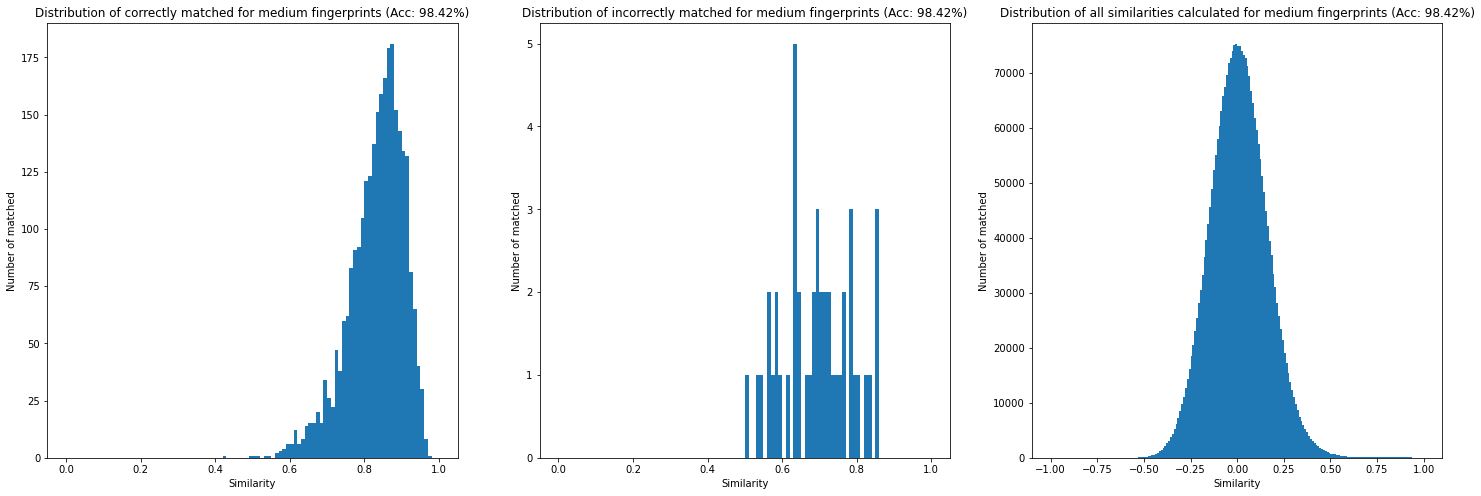

In [36]:
print("=======================================")
print("= Only considering the medium samples =")
print("=======================================")

easy_indices = [i
                for i, id in enumerate(query_ids)
                if "/Altered-Medium/" in id2path[id]]
plot_result("medium", set(easy_indices))

### Histograms for the hard subset of test dataset

= Only considering the hard samples =

Got 2311 right out of 2366, that's 97.68% accuracy



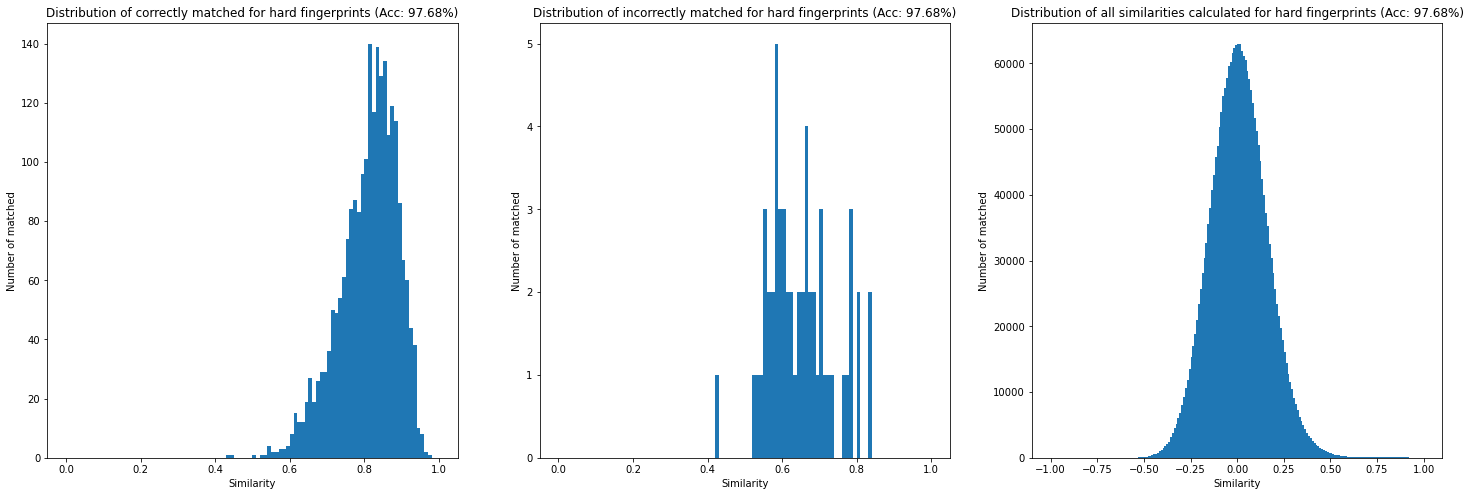

In [37]:
print("=====================================")
print("= Only considering the hard samples =")
print("=====================================")

easy_indices = [i
                for i, id in enumerate(query_ids)
                if "/Altered-Hard/" in id2path[id]]
plot_result("hard", set(easy_indices))

## 7. Conclusion

A Siamese model was used here to encode the fingerprints into vectors in a way that the dot product of the encoded vectors represents their similarity. The trained model managed to match 8188 altered fingerprints to their 1000 original version with 98% accuracy.

While the altered version of the fingerprints in the dataset were split into three difficulty levels, they were the same to the model as it managed to match them with the same accuracy.

## 8. Credits

I must admit that the code used here is mostly borrowed from the [Coursera's NLP Specialization](https://www.coursera.org/specializations/natural-language-processing). 